In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam




In [10]:
file_path = 'data/data.csv'
df = pd.read_csv(file_path)
# Удаление указанных колонок
columns_to_drop = ['p00', 'p01', 'p07', 'p09', 'p10', 'p16', 'p17', 'p20']
df.drop(columns=columns_to_drop, inplace=True)

In [14]:



# Преобразование всех данных в числовой формат
df = df.apply(pd.to_numeric, errors='coerce')


# Создание меток для выхода из строя
# Последний цикл каждого двигателя считается как выход из строя
df['failure'] = df.groupby('id')['cycle'].transform(lambda x: x == x.max()).astype(int)

# Подготовка данных для обучения
sequence_length = 100

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data.iloc[i:(i + seq_length), :-1].values
        y = data.iloc[i + seq_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Отбор данных для обучения и тестирования
train_df = df[df['id'] <= 10]
test_df = df[df['id'] == 11]

# Стандартизация данных
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(train_df.drop(columns=['id', 'cycle', 'failure']))
scaled_test_features = scaler.transform(test_df.drop(columns=['id', 'cycle', 'failure']))

# Создание DataFrame с масштабированными данными
scaled_train_df = pd.DataFrame(scaled_train_features, columns=train_df.columns[:-3])
scaled_train_df['failure'] = train_df['failure'].values

scaled_test_df = pd.DataFrame(scaled_test_features, columns=test_df.columns[:-3])
scaled_test_df['failure'] = test_df['failure'].values

# Создание последовательностей
X_train, y_train = create_sequences(scaled_train_df, sequence_length)
X_test, y_test = create_sequences(scaled_test_df, sequence_length)

# Создание и обучение модели LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Оценка модели
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Прогнозирование выхода из строя для новых данных
failure_prediction = model.predict(X_test)
print("Failure Prediction for new data:\n", failure_prediction)

Epoch 1/10
26/26 [==============================] - 10s 189ms/step - loss: 0.2784 - accuracy: 0.9527 - val_loss: 0.0299 - val_accuracy: 0.9951
Epoch 2/10
26/26 [==============================] - 4s 139ms/step - loss: 0.0316 - accuracy: 0.9951 - val_loss: 0.0263 - val_accuracy: 0.9951
Epoch 3/10
26/26 [==============================] - 4s 143ms/step - loss: 0.0258 - accuracy: 0.9951 - val_loss: 0.0229 - val_accuracy: 0.9951
Epoch 4/10
26/26 [==============================] - 4s 147ms/step - loss: 0.0246 - accuracy: 0.9951 - val_loss: 0.0222 - val_accuracy: 0.9951
Epoch 5/10
26/26 [==============================] - 4s 137ms/step - loss: 0.0222 - accuracy: 0.9951 - val_loss: 0.0189 - val_accuracy: 0.9951
Epoch 6/10
26/26 [==============================] - 4s 138ms/step - loss: 0.0227 - accuracy: 0.9951 - val_loss: 0.0181 - val_accuracy: 0.9951
Epoch 7/10
26/26 [==============================] - 4s 140ms/step - loss: 0.0218 - accuracy: 0.9951 - val_loss: 0.0172 - val_accuracy: 0.9951
Epoch

5/5 [==============================] - 0s 27ms/step
Failure Prediction (probability):
 [[0.00023199]
 [0.00023313]
 [0.00023142]
 [0.00023808]
 [0.00022856]
 [0.00023423]
 [0.00023223]
 [0.00023247]
 [0.00023626]
 [0.00023917]
 [0.0002345 ]
 [0.00023156]
 [0.00023422]
 [0.00023447]
 [0.00023571]
 [0.0002286 ]
 [0.00022999]
 [0.00022727]
 [0.00023074]
 [0.00023216]
 [0.00023244]
 [0.00023768]
 [0.00023621]
 [0.00023112]
 [0.00023161]
 [0.00023552]
 [0.00023665]
 [0.00023445]
 [0.00023547]
 [0.00023724]
 [0.00023363]
 [0.00023753]
 [0.00023173]
 [0.00022752]
 [0.00023599]
 [0.0002333 ]
 [0.00023098]
 [0.00022947]
 [0.0002289 ]
 [0.00024012]
 [0.00023443]
 [0.00024039]
 [0.00023517]
 [0.00023149]
 [0.00022732]
 [0.00023442]
 [0.00023349]
 [0.00024516]
 [0.00024   ]
 [0.0002432 ]
 [0.00023803]
 [0.00023526]
 [0.00024072]
 [0.00024671]
 [0.00023783]
 [0.00023635]
 [0.00023177]
 [0.00023508]
 [0.00023126]
 [0.00023223]
 [0.0002372 ]
 [0.0002334 ]
 [0.000232  ]
 [0.00023134]
 [0.00022901]
 [0

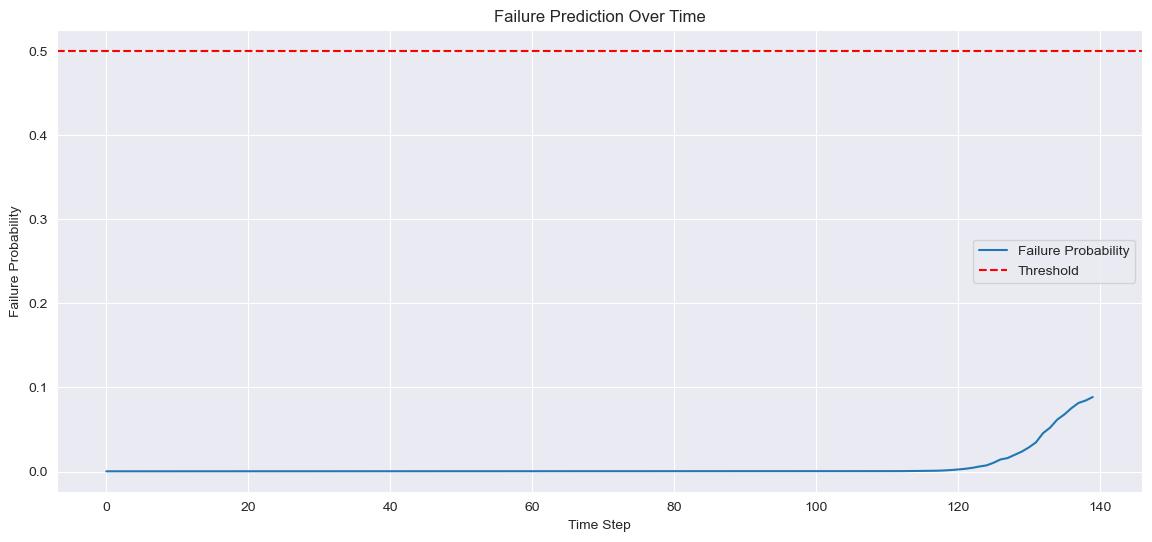

In [15]:
# Прогнозирование выхода из строя для новых данных
failure_prediction = model.predict(X_test)

# Установка порогового значения
threshold = 0.5

# Интерпретация прогнозов
failure_prediction_interpreted = (failure_prediction > threshold).astype(int)

# Вывод интерпретации прогнозов
print("Failure Prediction (probability):\n", failure_prediction)
print("Failure Prediction (interpreted):\n", failure_prediction_interpreted)

# Анализ последовательности прогнозов
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(failure_prediction, label='Failure Probability')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.xlabel('Time Step')
plt.ylabel('Failure Probability')
plt.title('Failure Prediction Over Time')
plt.legend()
plt.show()


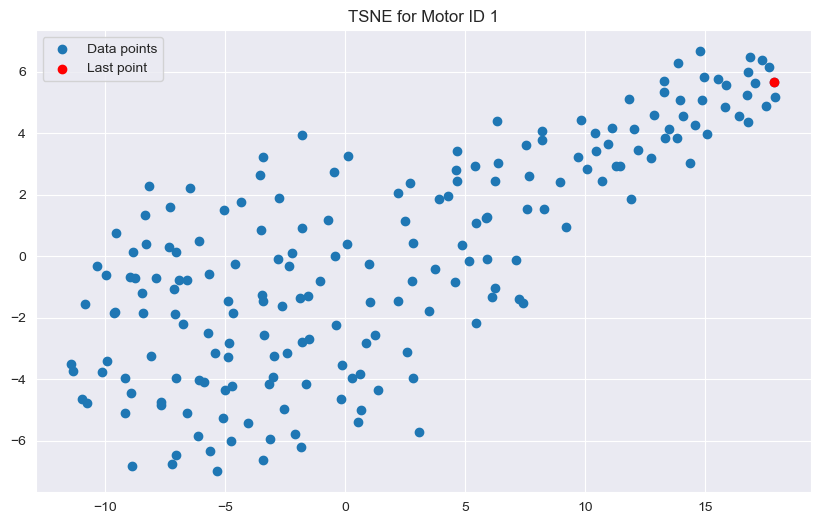

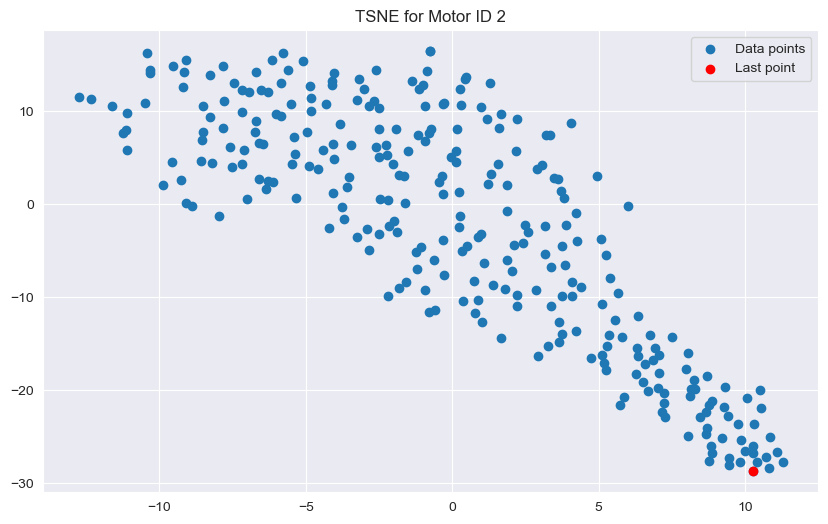

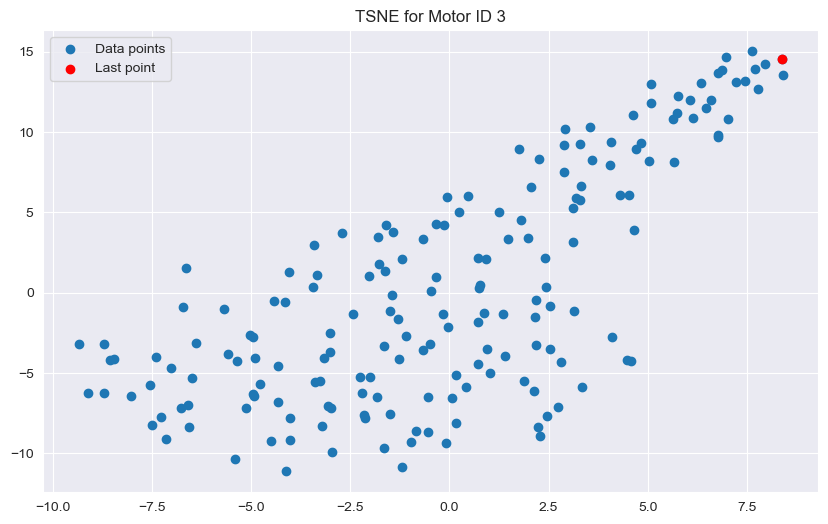

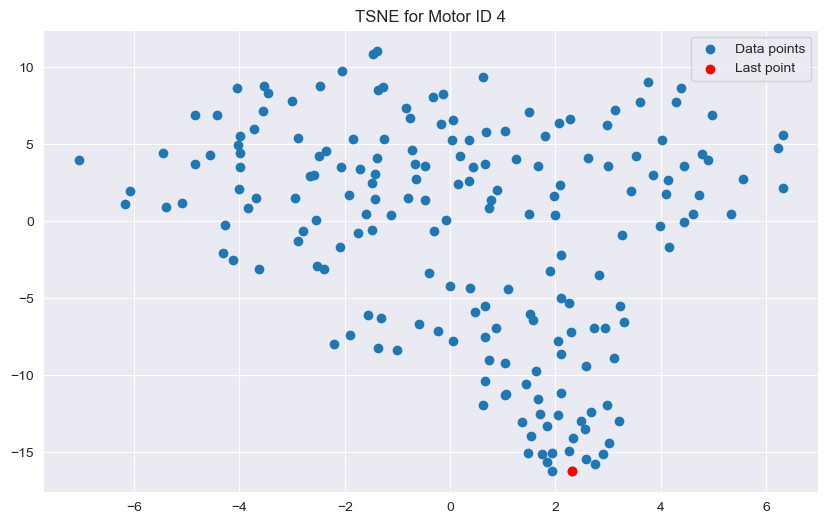

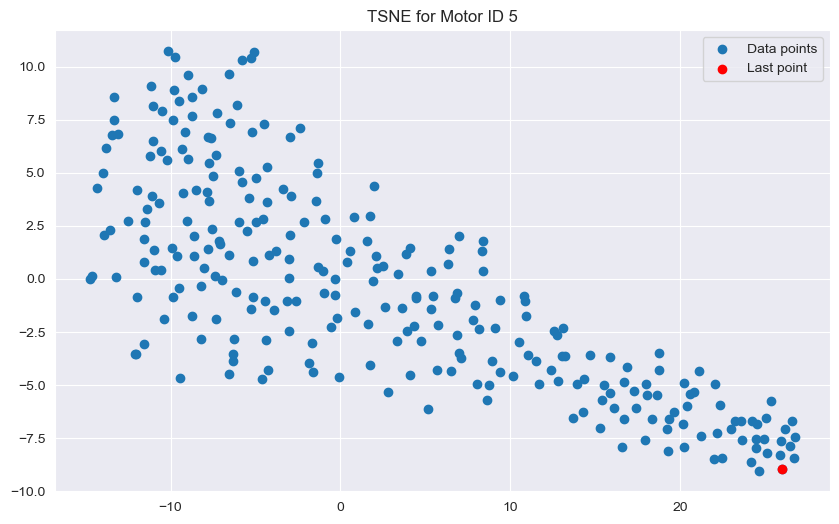

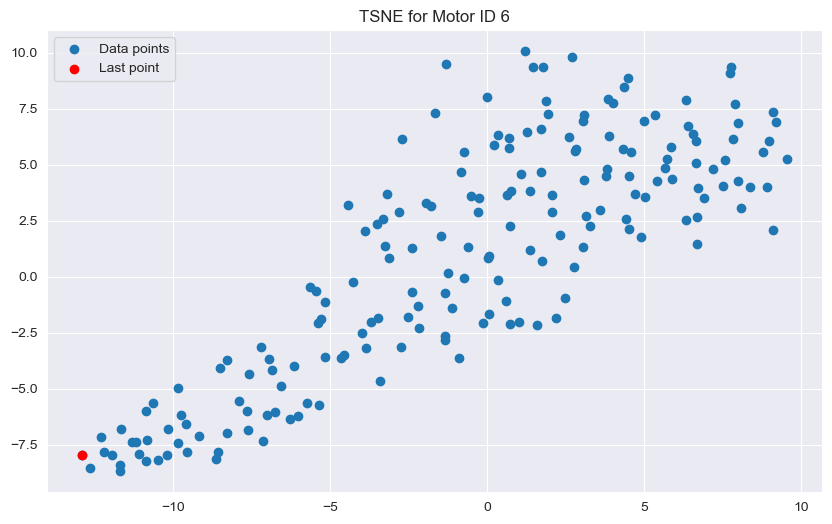

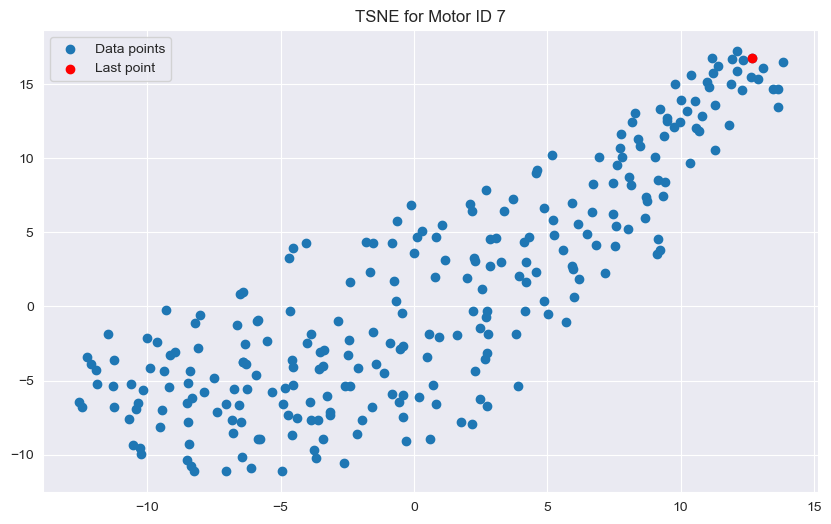

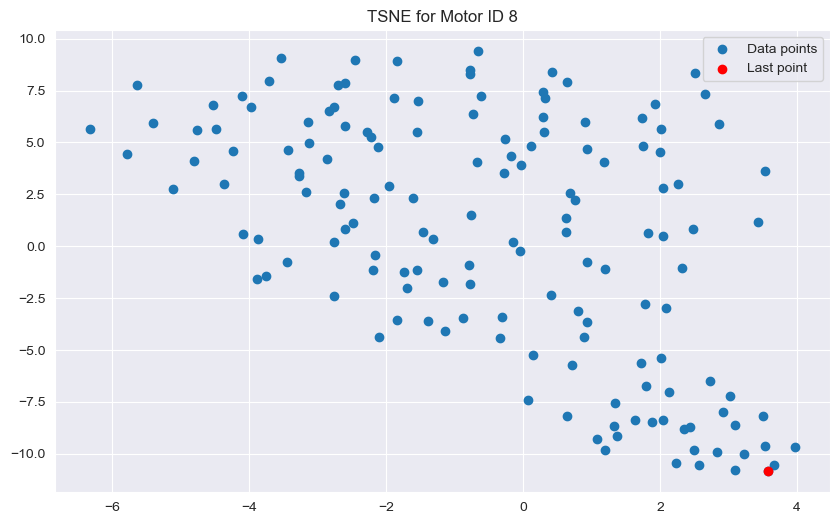

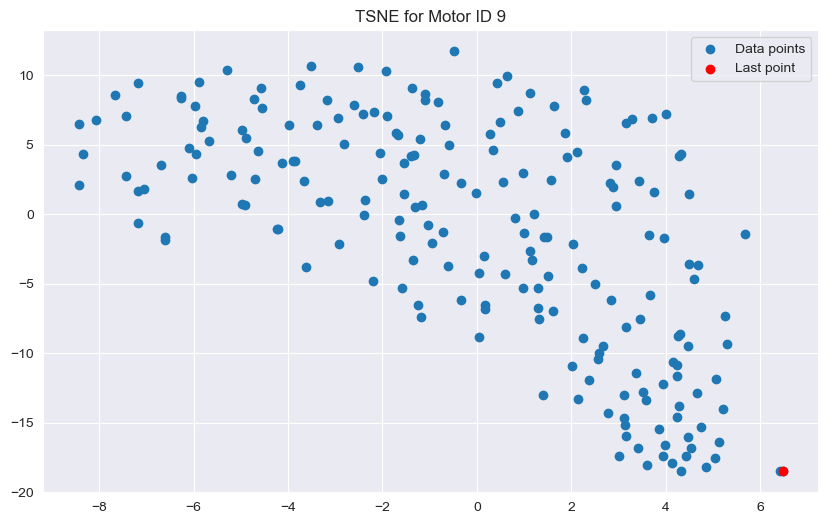

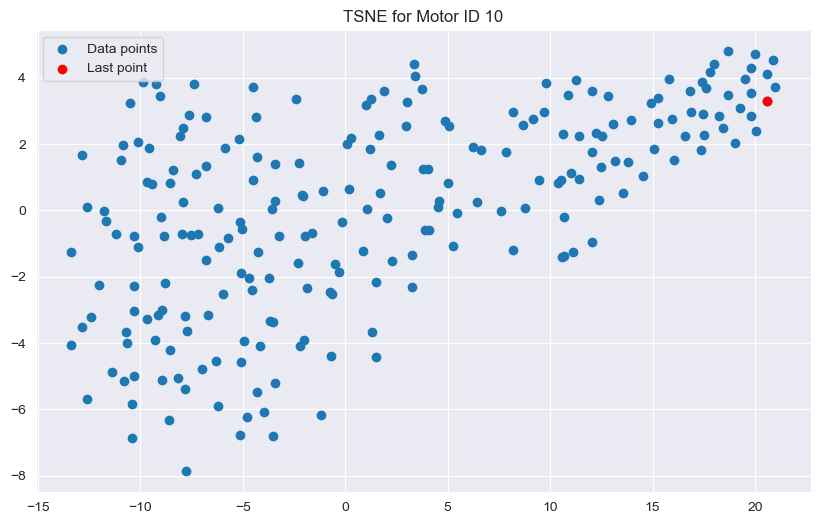

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Загрузка данных
file_path = 'data/data.csv'
df = pd.read_csv(file_path)

# Удаление указанных колонок
columns_to_drop = ['p00', 'p01', 'p07', 'p09', 'p10', 'p16', 'p17', 'p20', 's1', 's2']
df.drop(columns=columns_to_drop, inplace=True)

# Преобразование всех данных в числовой формат
df = df.apply(pd.to_numeric, errors='coerce')

# Заполнение пропущенных значений
df.fillna(df.median(), inplace=True)

# Создание меток для выхода из строя
df['failure'] = df.groupby('id')['cycle'].transform(lambda x: x == x.max()).astype(int)

def scale_and_plot_tsne(df, motor_id):
    # Отбор данных для конкретного двигателя
    motor_data = df[df['id'] == motor_id]

    # Стандартизация данных
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(motor_data.drop(columns=['id', 'cycle', 'failure']))

    # Применение t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(scaled_features)

    # Последняя точка
    last_point_index = motor_data[motor_data['failure'] == 1].index[-1] - motor_data.index[0]

    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], label='Data points')
    plt.scatter(tsne_results[last_point_index, 0], tsne_results[last_point_index, 1], color='red', label='Last point')
    plt.title(f'TSNE for Motor ID {motor_id}')
    plt.legend()
    plt.show()

# Построение графиков t-SNE для первых 10 двигателей
for motor_id in range(1, 11):
    scale_and_plot_tsne(df, motor_id)


In [20]:
file_path = 'data/data.csv'
df = pd.read_csv(file_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      16138 non-null  int64  
 1   cycle   16138 non-null  int64  
 2   p00     16138 non-null  float64
 3   p01     16138 non-null  float64
 4   p02     16138 non-null  float64
 5   p03     16138 non-null  float64
 6   p04     16138 non-null  float64
 7   p05     16138 non-null  float64
 8   p06     16138 non-null  float64
 9   p07     16138 non-null  float64
 10  p08     16138 non-null  int64  
 11  p09     16138 non-null  int64  
 12  p10     16138 non-null  int64  
 13  p11     16138 non-null  float64
 14  p12     16138 non-null  float64
 15  p13     16138 non-null  float64
 16  p14     16138 non-null  float64
 17  p15     16138 non-null  float64
 18  p16     16138 non-null  float64
 19  p17     16138 non-null  float64
 20  p18     16138 non-null  float64
 21  p19     16138 non-null  float64
 22

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


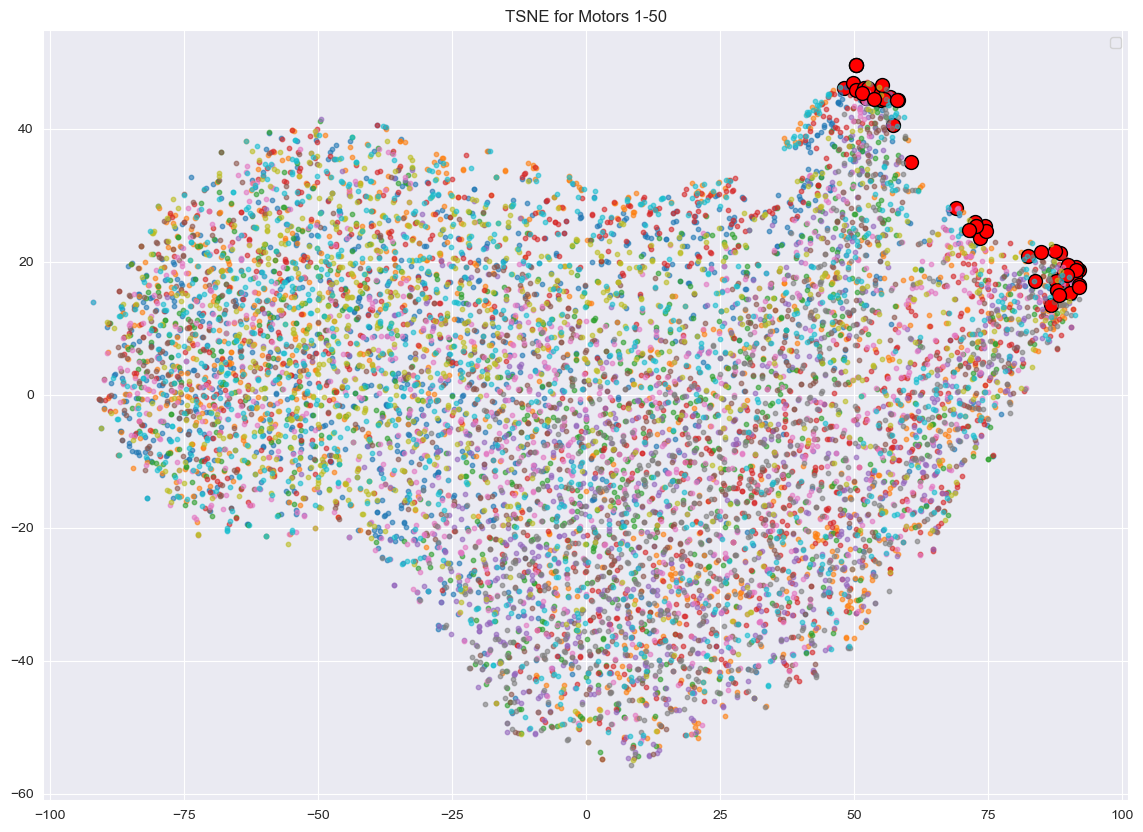

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Загрузка данных
file_path = 'data/data.csv'
df = pd.read_csv(file_path)

# Удаление указанных колонок
columns_to_drop = ['p00', 'p01', 'p07', 'p09', 'p10', 'p16', 'p17', 'p20', 's1', 's2']
df.drop(columns=columns_to_drop, inplace=True)

# Преобразование всех данных в числовой формат
df = df.apply(pd.to_numeric, errors='coerce')

# Заполнение пропущенных значений
df.fillna(df.median(), inplace=True)

# Создание меток для выхода из строя
df['failure'] = df.groupby('id')['cycle'].transform(lambda x: x == x.max()).astype(int)

# Задаем количество двигателей для отображения
num_motors = 50  # можно изменить это значение

# Отбор данных для указанных двигателей
df = df[df['id'] <= num_motors]

# Стандартизация данных
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['id', 'cycle', 'failure']))

scaled_df = pd.DataFrame(scaled_features, columns=df.columns[:-3])
scaled_df['id'] = df['id'].values
scaled_df['cycle'] = df['cycle'].values
scaled_df['failure'] = df['failure'].values

# Применение t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(scaled_features)

# Визуализация
plt.figure(figsize=(14, 10))
colors = plt.cm.tab10(np.linspace(0, 1, num_motors))

for motor_id in range(1, num_motors + 1):
    motor_data = scaled_df[scaled_df['id'] == motor_id]
    indices = motor_data.index
    last_point_index = motor_data[motor_data['failure'] == 1].index[-1] - motor_data.index[0]

    # Отображаем все точки одного двигателя
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], color=colors[motor_id-1], s=10, alpha=0.6)
    # Отображаем последнюю точку одного двигателя
    # plt.scatter(tsne_results[indices[last_point_index], 0], tsne_results[indices[last_point_index], 1], color='red', edgecolor='black', s=100, label=f'Motor ID {motor_id} Last Point')
    plt.scatter(tsne_results[indices[last_point_index], 0], tsne_results[indices[last_point_index], 1], color='red', edgecolor='black', s=100)

plt.title(f'TSNE for Motors 1-{num_motors}')
plt.legend()
plt.show()
